# Feature engineering on sensor data - how to overcome feature explosion

The purpose of this notebook is to illustrate how we can overcome the feature explosion problem based on an example dataset involving sensor data.


Summary:

- Prediction type: __Regression__
- Domain: __Robotics__
- Prediction target: __The force vector on the robot's arm__ 
- Population size: __15001__

_Author: Dr. Patrick Urbanke_

## Feature explosion 

### The problem

The feature explosion problem is one of the most important issues in automated feature engineering. In fact, it is probably the main reason why automated feature engineering is not already the norm in data science projects involving business data.

To illustrate the problem, consider how data scientists write features for a simple time series problem:

```sql
SELECT SOME_AGGREGATION(t2.some_column)
FROM some_table t1
LEFT JOIN some_table t2
ON t1.join_key = t2.join_key
WHERE t2.some_other_column >= some_value
AND t2.rowid <= t1.rowid
AND t2.rowid + some_other_value > t1.rowid
GROUP BY t1.rowid;
```

Think about that for a second. 

Every column that we have can either be aggregated (*some_column*) or it can be used for our conditions (*some_other_column*). That means if we have *n* columns to aggregate, we can potentially build conditions for $n$ other columns. In other words, the computational complexity is $n^2$ in the number of columns.

Note that this problem occurs regardless of whether you automate feature engineering or you do it by hand. The size of the search space is $n^2$ in the number of columns in either case, unless you can rule something out a-priori.

This problem is known as _feature explosion_.

### __The solution__

So when we have relational data or time series with many columns, what do we do? The answer is to write different features. Specifically, suppose we had features like this:

```sql
SELECT SOME_AGGREGATION(
    CASE 
         WHEN t2.some_column > some_value THEN weight1
         WHEN t2.some_column <= some_value THEN weight2
    END
)
FROM some_table t1
LEFT JOIN some_table t2
ON t1.join_key = t2.join_key
WHERE t2.rowid <= t1.rowid
AND t2.rowid + some_other_value > t1.rowid
GROUP BY t1.rowid;
```

*weight1* and *weight2* are learnable weights. An algorithm that generates features like this can only use columns for conditions, it is not allowed to aggregate columns – and it doesn't need to do so.

That means the computational complexity is linear instead of quadratic. For data sets with a large number of columns this can make all the difference in the world. For instance, if you have 100 columns the size of the search space of the second approach is only 1% of the size of the search space of the first one.

getML features an algorithm called *relboost*, which generates features according to this principle and is therefore very suitable for data sets with many columns.

## The data set

To illustrate the problem, we use a data set related to robotics. When robots interact with humans, the most important think is that they don't hurt people. In order to prevent such accidents, the *force vector* on the robot's arm is measured. However, measuring the force vector is expensive.

Therefore, we want consider an alternative approach. We would like to predict the force vector based on other sensor data that are less costly to measure. To do so, we use *machine learning*.

However, the data set contains measurements from almost 100 different sensors and we do not know which and how many sensors are relevant for predicting the force vector.

The data set has been generously provided by Erik Berger who originally collected it for his dissertation:

> Berger, E. (2018). *Behavior-Specific Proprioception Models for Robotic Force Estimation: A Machine Learning Approach.* Freiberg, Germany: Technische Universitaet Bergakademie Freiberg.

## A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

## 1. Loading data

We begin by importing the libraries and setting the project.

In [1]:
import datetime
import os
from urllib import request

import pandas as pd
import numpy as np
import getml
import getml.data as data
import getml.database as database
import getml.engine as engine
import getml.feature_learning.aggregations as agg
import getml.data.roles as roles

from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  
 
getml.engine.set_project('robot')


Connected to project 'robot'


### 1.1 Download from source


In [2]:
fname = "robot-demo.csv"

if not os.path.exists(fname):
    fname, res = request.urlretrieve(
        "https://static.getml.com/datasets/robotarm/" + fname, 
        fname
    )

In [3]:
data_all = getml.data.DataFrame.from_csv("robot-demo.csv", "data_all")

In [4]:
data_all

Name,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,98,99,100,101,102,103,104,105,106,f_x,f_y,f_z
Role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float
0,3.4098,-0.32737,0.96044,-3.7436,-1.0191,-6.0205,0,0,0,0,0,0,0,0,0,0,0,0,8.3804e-17,-4.8116,-1.4033,-0.13686,0.0024719,0,9.8027e-16,-55.642,-16.312,-1.2042,0.021675,0,3.4098,-0.32739,0.96045,-3.7437,-1.0191,-6.0205,0,0,0,0,0,0,0.1233,-6.5483,-2.8045,-0.82962,0.076252,-0.19063,0.12106,-6.5483,-2.8157,-0.8281,0.070152,-0.19826,0.7699,0.41002,0.082791,-1.4094,0.78597,-0.3682,0,0,0,0,0,0,-22.654,-11.503,-18.673,-3.5155,5.8354,-2.05,0.7699,0.41004,0.082782,-1.4094,0.786,-0.36813,0,0,0,0,0,0,48.069,48.009,0.9668,47.834,47.925,47.818,47.834,47.955,47.971,-11.03,6.9,-7.33
1,3.4098,-0.32737,0.96044,-3.7436,-1.0191,-6.0205,0,0,0,0,0,0,0,0,0,0,0,0,8.3804e-17,-4.8116,-1.4033,-0.13686,0.0024719,0,9.8027e-16,-55.642,-16.312,-1.2042,0.021675,0,3.4098,-0.32739,0.96044,-3.7437,-1.0191,-6.0205,0,0,0,0,0,0,0.11882,-6.5506,-2.8404,-0.8281,0.064052,-0.19978,0.12106,-6.5483,-2.8157,-0.8281,0.070152,-0.19826,0.7699,0.41002,0.0828,-1.4094,0.78592,-0.36821,0,0,0,0,0,0,-21.627,-11.046,-18.66,-3.5395,5.7577,-1.9805,0.7699,0.41004,0.082782,-1.4094,0.786,-0.36813,0,0,0,0,0,0,48.009,48.009,0.85938,47.834,47.925,47.818,47.834,47.955,47.971,-10.848,6.7218,-7.4427
2,3.4098,-0.32737,0.96044,-3.7436,-1.0191,-6.0205,0,0,0,0,0,0,0,0,0,0,0,0,8.3804e-17,-4.8116,-1.4033,-0.13686,0.0024719,0,9.8027e-16,-55.642,-16.312,-1.2042,0.021675,0,3.4098,-0.32737,0.96045,-3.7437,-1.0191,-6.0205,0,0,0,0,0,0,0.10985,-6.5438,-2.8,-0.82047,0.074727,-0.183,0.12106,-6.5483,-2.8157,-0.8281,0.070152,-0.19216,0.7699,0.41002,0.082786,-1.4094,0.78594,-0.36819,0,0,0,0,0,0,-23.843,-12.127,-18.393,-3.6453,5.978,-1.9978,0.7699,0.41004,0.082782,-1.4094,0.786,-0.36813,0,0,0,0,0,0,48.009,48.069,0.93099,47.879,47.925,47.818,47.834,47.955,47.971,-10.666,6.5436,-7.5555
3,3.4098,-0.32737,0.96044,-3.7436,-1.0191,-6.0205,0,0,0,0,0,0,0,0,0,0,0,0,8.3804e-17,-4.8116,-1.4033,-0.13686,0.0024719,0,9.8027e-16,-55.642,-16.312,-1.2042,0.021675,0,3.4098,-0.32734,0.96044,-3.7437,-1.0191,-6.0205,0,0,0,0,0,0,0.1233,-6.5483,-2.8224,-0.82657,0.071677,-0.19978,0.12106,-6.5483,-2.8157,-0.8281,0.070152,-0.19673,0.7699,0.41003,0.082755,-1.4094,0.78599,-0.36815,0,0,0,0,0,0,-21.772,-10.872,-18.691,-3.5512,5.6648,-1.9976,0.7699,0.41004,0.082782,-1.4094,0.786,-0.36813,0,0,0,0,0,0,48.069,48.069,0.93099,47.879,47.925,47.818,47.834,47.955,47.971,-10.507,6.4533,-7.65
4,3.4098,-0.32737,0.96044,-3.7436,-1.0191,-6.0205,0,0,0,0,0,0,0,0,0,0,0,0,8.3804e-17,-4.8116,-1.4033,-0.13686,0.0024719,0,9.8027e-16,-55.642,-1

### 1.2 Prepare data for getML

The force vector consists of three component (*f_x*, *f_y* and *f_z*), meaning that we have three targets.

In [5]:
data_all.set_role(["f_x", "f_y", "f_z"], getml.data.roles.target)
data_all.set_role(data_all.unused_names, getml.data.roles.numerical)

This is what the data set looks like:

In [6]:
data_all

Name,f_x,f_y,f_z,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,98,99,100,101,102,103,104,105,106
Role,target,target,target,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
0,-11.03,6.9,-7.33,3.4098,-0.32737,0.96044,-3.7436,-1.0191,-6.0205,0,0,0,0,0,0,0,0,0,0,0,0,8.3804e-17,-4.8116,-1.4033,-0.13686,0.0024719,0,9.8027e-16,-55.642,-16.312,-1.2042,0.021675,0,3.4098,-0.32739,0.96045,-3.7437,-1.0191,-6.0205,0,0,0,0,0,0,0.1233,-6.5483,-2.8045,-0.82962,0.076252,-0.19063,0.12106,-6.5483,-2.8157,-0.8281,0.070152,-0.19826,0.7699,0.41002,0.082791,-1.4094,0.78597,-0.3682,0,0,0,0,0,0,-22.654,-11.503,-18.673,-3.5155,5.8354,-2.05,0.7699,0.41004,0.082782,-1.4094,0.786,-0.36813,0,0,0,0,0,0,48.069,48.009,0.9668,47.834,47.925,47.818,47.834,47.955,47.971
1,-10.848,6.7218,-7.4427,3.4098,-0.32737,0.96044,-3.7436,-1.0191,-6.0205,0,0,0,0,0,0,0,0,0,0,0,0,8.3804e-17,-4.8116,-1.4033,-0.13686,0.0024719,0,9.8027e-16,-55.642,-16.312,-1.2042,0.021675,0,3.4098,-0.32739,0.96044,-3.7437,-1.0191,-6.0205,0,0,0,0,0,0,0.11882,-6.5506,-2.8404,-0.8281,0.064052,-0.19978,0.12106,-6.5483,-2.8157,-0.8281,0.070152,-0.19826,0.7699,0.41002,0.0828,-1.4094,0.78592,-0.36821,0,0,0,0,0,0,-21.627,-11.046,-18.66,-3.5395,5.7577,-1.9805,0.7699,0.41004,0.082782,-1.4094,0.786,-0.36813,0,0,0,0,0,0,48.009,48.009,0.85938,47.834,47.925,47.818,47.834,47.955,47.971
2,-10.666,6.5436,-7.5555,3.4098,-0.32737,0.96044,-3.7436,-1.0191,-6.0205,0,0,0,0,0,0,0,0,0,0,0,0,8.3804e-17,-4.8116,-1.4033,-0.13686,0.0024719,0,9.8027e-16,-55.642,-16.312,-1.2042,0.021675,0,3.4098,-0.32737,0.96045,-3.7437,-1.0191,-6.0205,0,0,0,0,0,0,0.10985,-6.5438,-2.8,-0.82047,0.074727,-0.183,0.12106,-6.5483,-2.8157,-0.8281,0.070152,-0.19216,0.7699,0.41002,0.082786,-1.4094,0.78594,-0.36819,0,0,0,0,0,0,-23.843,-12.127,-18.393,-3.6453,5.978,-1.9978,0.7699,0.41004,0.082782,-1.4094,0.786,-0.36813,0,0,0,0,0,0,48.009,48.069,0.93099,47.879,47.925,47.818,47.834,47.955,47.971
3,-10.507,6.4533,-7.65,3.4098,-0.32737,0.96044,-3.7436,-1.0191,-6.0205,0,0,0,0,0,0,0,0,0,0,0,0,8.3804e-17,-4.8116,-1.4033,-0.13686,0.0024719,0,9.8027e-16,-55.642,-16.312,-1.2042,0.021675,0,3.4098,-0.32734,0.96044,-3.7437,-1.0191,-6.0205,0,0,0,0,0,0,0.1233,-6.5483,-2.8224,-0.82657,0.071677,-0.19978,0.12106,-6.5483,-2.8157,-0.8281,0.070152,-0.19673,0.7699,0.41003,0.082755,-1.4094,0.78599,-0.36815,0,0,0,0,0,0,-21.772,-10.872,-18.691,-3.5512,5.6648,-1.9976,0.7699,0.41004,0.082782,-1.4094,0.786,-0.36813,0,0,0,0,0,0,48.069,48.069,0.93099,47.879,47.925,47.818,47.834,47.955,47.971
4,-10.413,6.6267,-7.69,3.4098,-0.32737,0.96044,-3.7436,-1.0191,-6.0205,0,0,0,0,0,0,0,0,0,0,0,0,8.3804e-17,-4.8116,-1.4033,-0.13686,0.0024719,0,9.8027e-16,-55.642,-16.312,-1.2042,0.021675,0,3.4098,-0.32736,0.96042,-3.7437,-1.0191,-6.0205,0,0,0,0,0,0,0.12554,-6.5394,-2.8,-0.83267,0.074727,-0.19521,0.12106,-6.5483,-2.8157,-0.83267,0.070152,-0.19216,0.7699,0.41003,0.082782,-1.4094,0.78597,-0.36815,0,0,0,0,0,0,-22.823,-11.645,-18.524,-3.5305

### 1.3 Separate data into a training and testing set

We also want to separate the data set into a training and testing set. We do so by using the first 10,500 measurements for training and then using the remainder for testing.

In [7]:
separator = 10500

data_train = data_all.where("data_train", data_all.rowid() < separator)
data_test = data_all.where("data_test", data_all.rowid() >= separator)

## 2. Predictive modelling

### 2.1 Building the pipeline

We then build a pipeline based on the *relboost* algorithm with *xgboost* as our predictor.

In [8]:
relboost = getml.feature_learning.RelboostTimeSeries(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_features=10,
    allow_lagged_targets=False,
    memory=30
)

xgboost = getml.predictors.XGBoostRegressor(n_jobs=7)

pipe1 = getml.pipeline.Pipeline(
    feature_learners=[relboost],
    predictors=xgboost
)

It is always a good idea to check the pipeline for any potential issues.

In [9]:
pipe1.check(data_train)

Checking data model...
OK.


### 2.2 Fitting the pipeline

In [10]:
pipe1.fit(data_train)

Checking data model...
OK.

Relboost: Training features...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:3m:5.831878



Pipeline(preprocessors=[], feature_learners=['RelboostTimeSeries'], 
         feature_selectors=[], include_categorical=False, peripheral=[], 
         population='POPULATION', predictors=['XGBoostRegressor'], tags=[], 
         share_selected_features=0.5)

url: http://localhost:1709/#/getpipeline/robot/VnxNSd/0/

### 2.3 Evaluating the pipeline

In [11]:
pipe1.score(data_test)


Relboost: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-02-17 10:39:52,data_train,f_x,0.44492,0.58523,0.99617
1,2021-02-17 10:39:52,data_train,f_y,0.51586,0.68133,0.98927
2,2021-02-17 10:39:52,data_train,f_z,0.27503,0.35760,0.99876
3,2021-02-17 10:39:54,data_test,f_x,0.57159,0.74259,0.99489
4,2021-02-17 10:39:54,data_test,f_y,0.57249,0.76807,0.98660
5,2021-02-17 10:39:54,data_test,f_z,0.29982,0.39279,0.99850


### 2.4 Feature importances

It is always a good idea to study the features the relational learning algorithm has extracted. We can do so in the feature view of the getML monitor. Open the monitor and select the models tab in the sidebar. You will see an overview over the trained pipelines. Select a pipeline to see the most essential summary plots.

If you want to document them inside your notebook, here is how you can do that.

The feature importance is calculated by xgboost based on the improvement of the optimizing criterium at each split in the decision tree and is normalized to 100%.

Also note that we have three different target (*f_x*, *f_y* and *f_z*) and that different features are relevant for different targets.

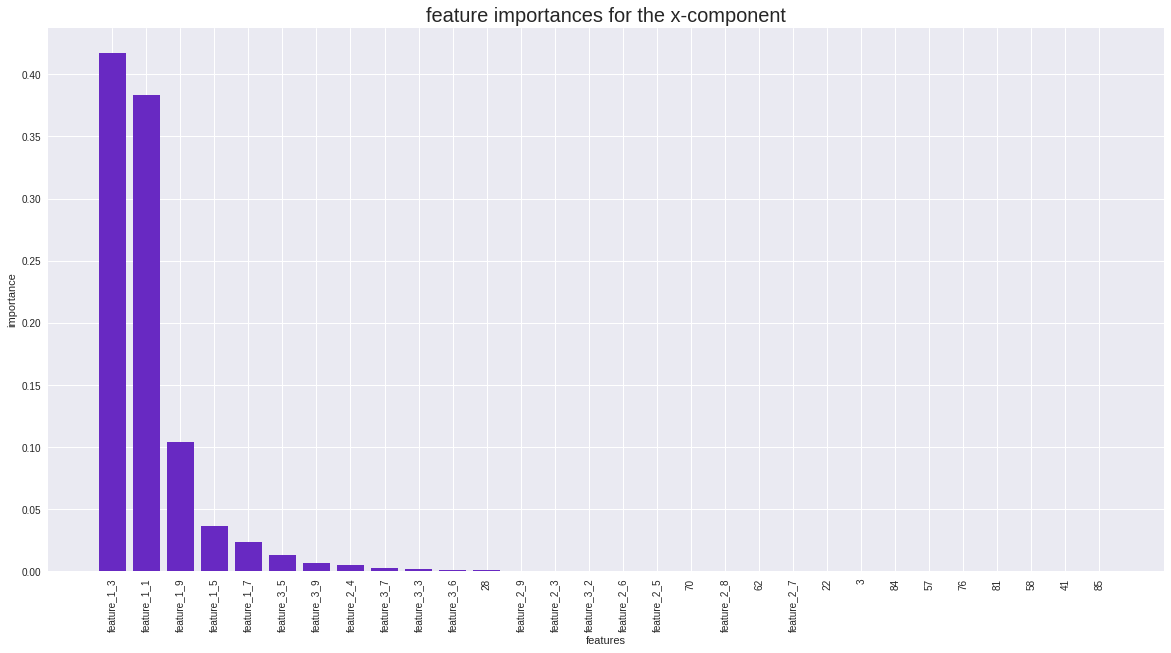

In [12]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.features.importances(target_num=0)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("feature importances for the x-component", size=20)
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

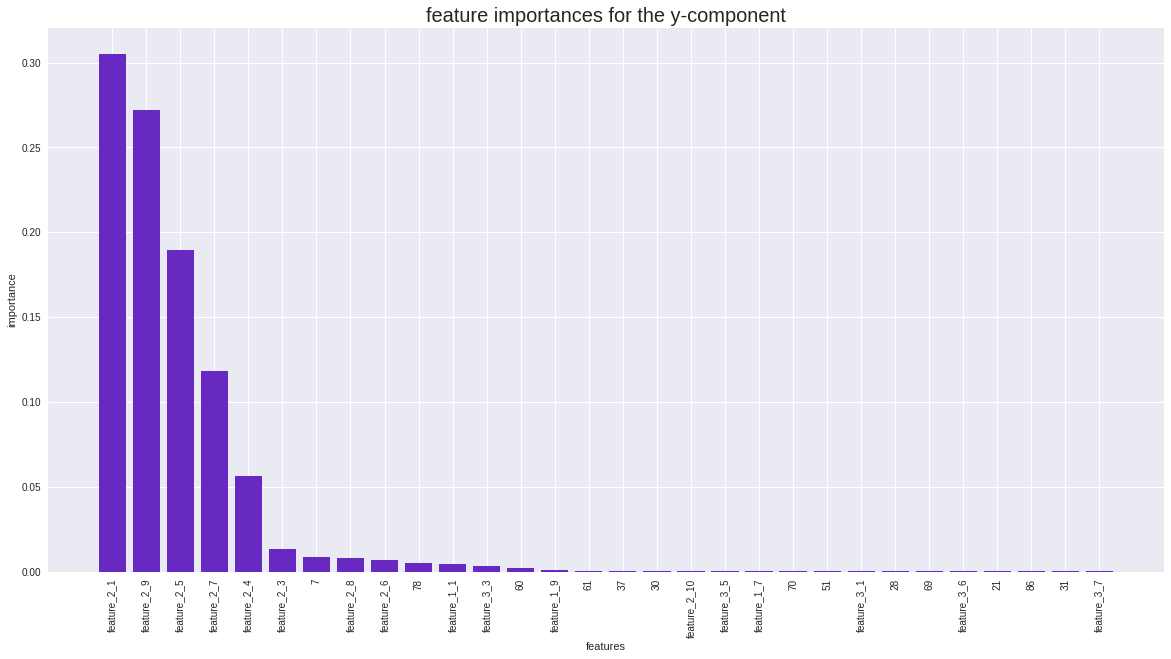

In [13]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.features.importances(target_num=1)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("feature importances for the y-component", size=20)
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

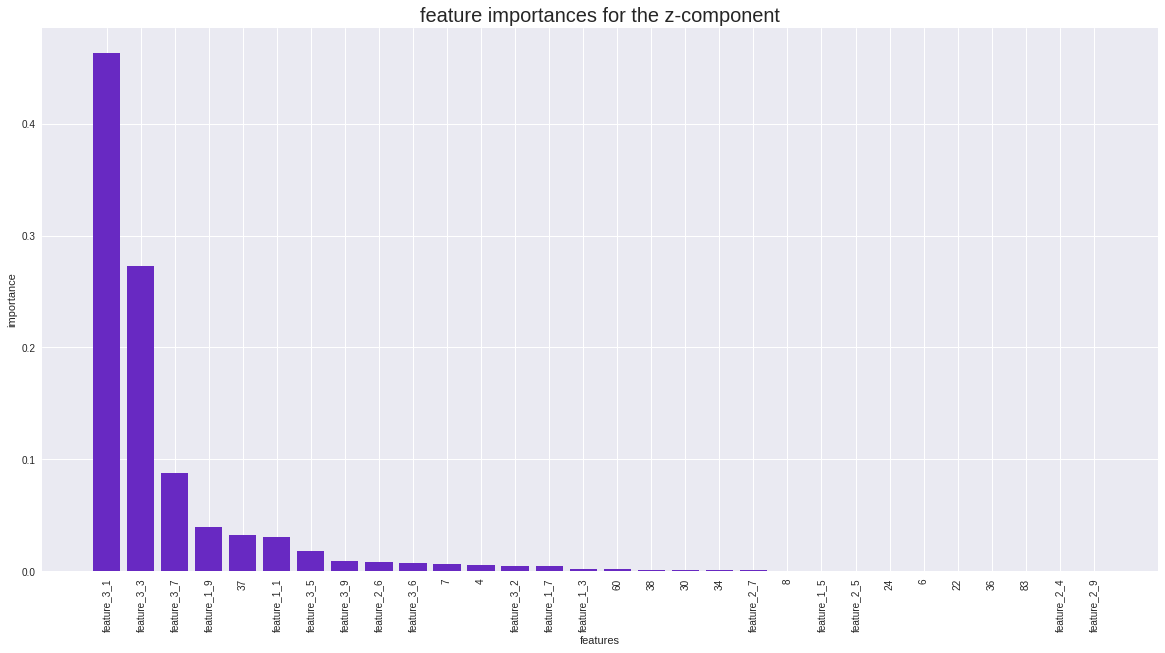

In [14]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.features.importances(target_num=2)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("feature importances for the z-component", size=20)
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

### 2.5 Column importances

Because getML is a tool for relational learning, we can also calculate the importances for the original columns, using similar methods we have used for the feature importances.

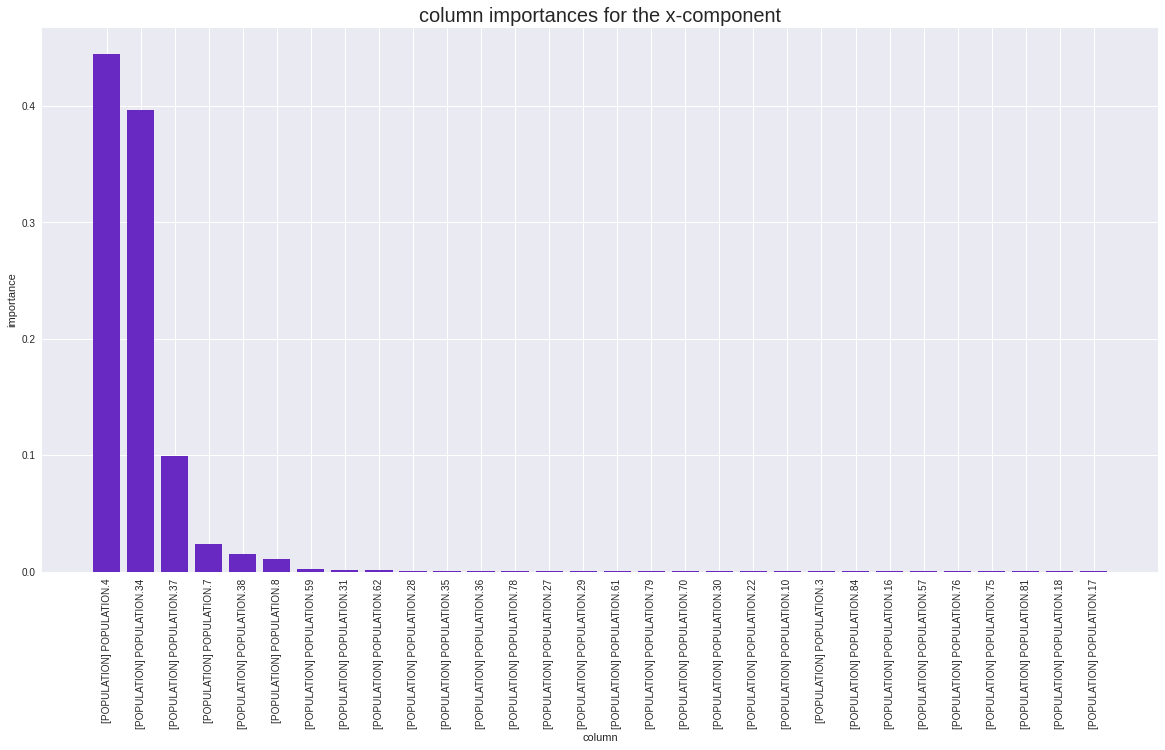

In [15]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.columns.importances(target_num=0)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("column importances for the x-component", size=20)
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

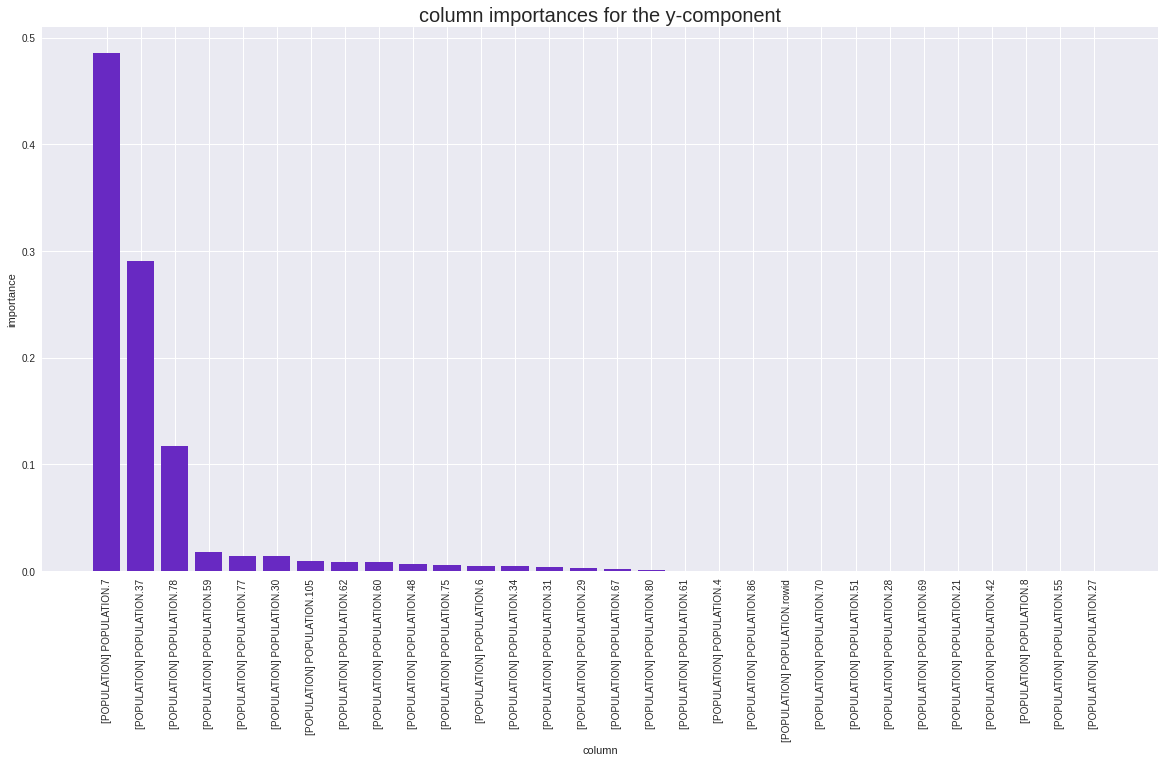

In [16]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.columns.importances(target_num=1)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("column importances for the y-component", size=20)
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

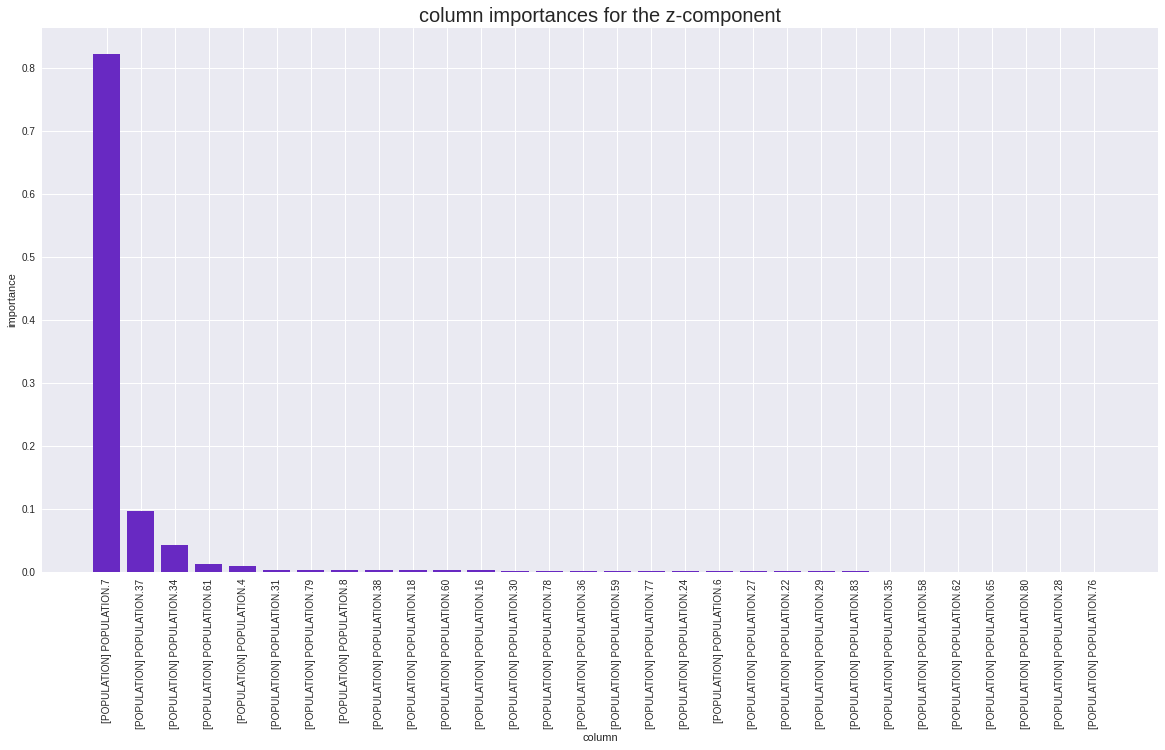

In [17]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.columns.importances(target_num=2)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("column importances for the z-component", size=20)
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

### 2.6 Column selection

When we study the plots for the *column importances* we find that there are some good news. We actually don't need that many columns. About 80% of the columns contain very little predictive value.

This means that we can also apply other algorithms that are not as scalable as *relboost*. All we have to do is to select the most relevant columns:

In [18]:
pipe1.columns.select(
    data_train, 
    share_selected_columns=0.2
)

The `.select(...)` method sets all but the most relevant columns to *unused*:

In [19]:
data_train

Name,f_x,f_y,f_z,4,6,7,8,29,30,31,34,37,38,48,59,60,61,62,75,77,78,105,79,18,16,67,80,36,28,35,27,70,22,86,24,51,84,58,83,69,57,21,3,42,10,76,82,23,55,85,64,45,66,103,17,68,65,46,81,41,39,74,56,50,43,104,72,25,106,40,63,9,101,33,54,53,71,47,12,52,44,11,102,49,5,73,14,26,98,100,20,99,19,13,15,32
Role,target,target,target,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float
0,-11.03,6.9,-7.33,-0.32737,-3.7436,-1.0191,-6.0205,-16.312,-1.2042,0.021675,-0.32739,-1.0191,-6.0205,-0.82962,0.082791,-1.4094,0.78597,-0.3682,0.7699,0.082782,-1.4094,47.955,0.786,0,0,0,-0.36813,-3.7437,-55.642,0.96045,9.8027e-16,-11.503,-4.8116,0,-0.13686,0.12106,0,0.41002,0,-22.654,0.7699,8.3804e-17,3.4098,0,0,0.41004,0,-1.4033,0.070152,0,0,0.1233,0,47.818,0,0,0,-6.5483,0,0,0,-2.05,-0.19826,-0.19063,0,47.834,-3.5155,0.0024719,47.971,0,0,0,47.834,3.4098,-0.8281,-2.8157,-18.673,-2.8045,0,-6.5483,0,0,47.925,0.076252,0.96044,5.8354,0,0,48.069,0.9668,0,48.009,0,0,0,0
1,-10.848,6.7218,-7.4427,-0.32737,-3.7436,-1.0191,-6.0205,-16.312,-1.2042,0.021675,-0.32739,-1.0191,-6.0205,-0.8281,0.0828,-1.4094,0.78592,-0.36821,0.7699,0.082782,-1.4094,47.955,0.786,0,0,0,-0.36813,-3.7437,-55.642,0.96044,9.8027e-16,-11.046,-4.8116,0,-0.13686,0.12106,0,0.41002,0,-21.627,0.7699,8.3804e-17,3.4098,0,0,0.41004,0,-1.4033,0.070152,0,0,0.11882,0,47.818,0,0,0,-6.5506,0,0,0,-1.9805,-0.19826,-0.19978,0,47.834,-3.5395,0.0024719,47.971,0,0,0,47.834,3.4098,-0.8281,-2.8157,-18.66,-2.8404,0,-6.5483,0,0,47.925,0.064052,0.96044,5.7577,0,0,48.009,0.85938,0,48.009,0,0,0,0
2,-10.666,6.5436,-7.5555,-0.32737,-3.7436,-1.0191,-6.0205,-16.312,-1.2042,0.021675,-0.32737,-1.0191,-6.0205,-0.82047,0.082786,-1.4094,0.78594,-0.36819,0.7699,0.082782,-1.4094,47.955,0.786,0,0,0,-0.36813,-3.7437,-55.642,0.96045,9.8027e-16,-12.127,-4.8116,0,-0.13686,0.12106,0,0.41002,0,-23.843,0.7699,8.3804e-17,3.4098,0,0,0.41004,0,-1.4033,0.070152,0,0,0.10985,0,47.818,0,0,0,-6.5438,0,0,0,-1.9978,-0.19216,-0.183,0,47.834,-3.6453,0.0024719,47.971,0,0,0,47.879,3.4098,-0.8281,-2.8157,-18.393,-2.8,0,-6.5483,0,0,47.925,0.074727,0.96044,5.978,0,0,48.009,0.93099,0,48.069,0,0,0,0
3,-10.507,6.4533,-7.65,-0.32737,-3.7436,-1.0191,-6.0205,-16.312,-1.2042,0.021675,-0.32734,-1.0191,-6.0205,-0.82657,0.082755,-1.4094,0.78599,-0.36815,0.7699,0.082782,-1.4094,47.955,0.786,0,0,0,-0.36813,-3.7437,-55.642,0.96044,9.8027e-16,-10.872,-4.8116,0,-0.13686,0.12106,0,0.41003,0,-21.772,0.7699,8.3804e-17,3.4098,0,0,0.41004,0,-1.4033,0.070152,0,0,0.1233,0,47.818,0,0,0,-6.5483,0,0,0,-1.9976,-0.19673,-0.19978,0,47.834,-3.5512,0.0024719,47.971,0,0,0,47.879,3.4098,-0.8281,-2.8157,-18.691,-2.8224,0,-6.5483,0,0,47.925,0.071677,0.96044,5.6648,0,0,48.069,0.93099,0,48.069,0,0,0,0
4,-10.413,6.6267,-7.69,-0.32737,-3.7436,-1.0191,-6.0205,-16.312,-1.2042,0.021675,-0.32736,-1.0191,-6.0205,-0.83267,0.082782,-1.4094,0.78597,-0.36815,0.7699,0.082782,-1.4094,47.955,0.786,0,0,0,-0.36813,-3.7437,-55.642,0

### 2.7 Fitting a second pipeline

The *multirel* algorithm does scale well do data sets with many columns. As we have discussed in the introduction, its computational complexity is $n^2$ in the number of columns. But now, we only use 20% of the original columns, meaning that it is fine to use multirel.

In [20]:
multirel =  getml.feature_learning.MultirelTimeSeries(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_features=10,
    allow_lagged_targets=False,
    memory=30
)

relboost = getml.feature_learning.RelboostTimeSeries(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_features=10,
    allow_lagged_targets=False,
    memory=30
)

xgboost = getml.predictors.XGBoostRegressor(n_jobs=7)

pipe2 = getml.pipeline.Pipeline(
    feature_learners=[multirel, relboost],
    predictors=xgboost
)

In [21]:
pipe2.check(data_train)

Checking data model...
OK.


In [22]:
pipe2.fit(data_train)

Checking data model...
OK.

Multirel: Training features...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Multirel: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:3m:23.84591



Pipeline(preprocessors=[], 
         feature_learners=['MultirelTimeSeries', 'RelboostTimeSeries'], 
         feature_selectors=[], include_categorical=False, peripheral=[], 
         population='POPULATION', predictors=['XGBoostRegressor'], tags=[], 
         share_selected_features=0.5)

url: http://localhost:1709/#/getpipeline/robot/GUuAzO/0/

In [23]:
pipe2.score(data_test)


Multirel: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-02-17 10:43:22,data_train,f_x,0.45098,0.59553,0.99603
1,2021-02-17 10:43:22,data_train,f_y,0.52784,0.69414,0.98886
2,2021-02-17 10:43:22,data_train,f_z,0.27171,0.35790,0.99876
3,2021-02-17 10:43:24,data_test,f_x,0.57508,0.75383,0.99474
4,2021-02-17 10:43:24,data_test,f_y,0.56989,0.76599,0.98668
5,2021-02-17 10:43:24,data_test,f_z,0.30450,0.42346,0.99826


### 2.8 Visualizing the predictions

Sometimes a picture says more than a 1000 words. We therefore want to visualize our predictions on the testing set.

In [24]:
f_x = data_test["f_x"].to_numpy()
f_y = data_test["f_y"].to_numpy()
f_z = data_test["f_z"].to_numpy()

In [25]:
predictions = pipe2.predict(data_test)


Multirel: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%



In [26]:
col_data = 'black'
col_getml = 'darkviolet'
col_getml_alt = 'coral'

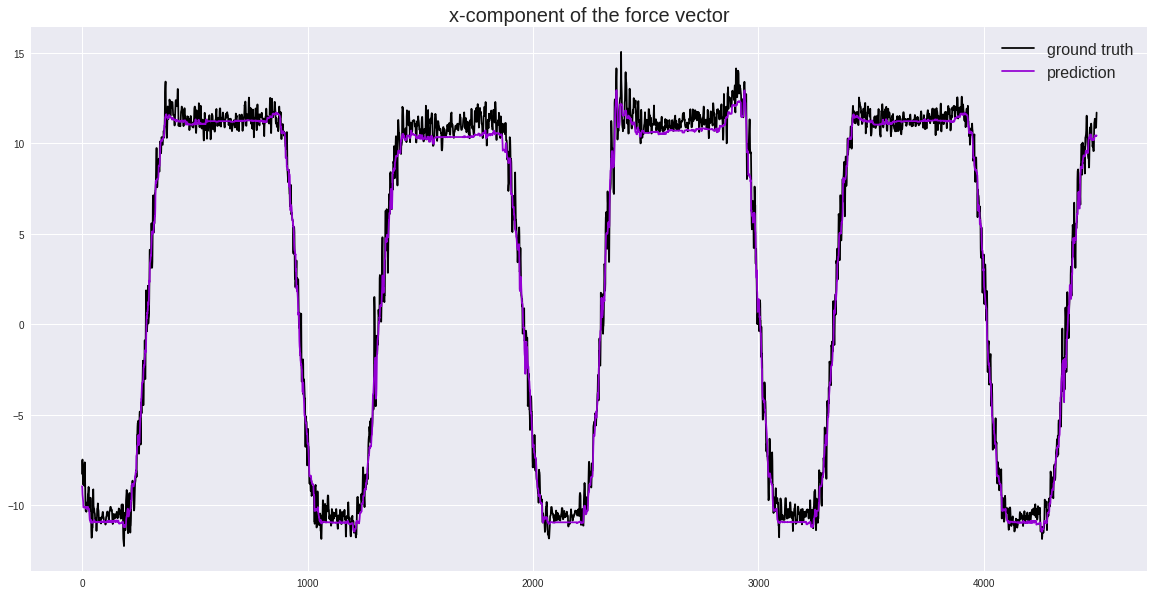

In [27]:
plt.subplots(figsize=(20, 10))

plt.title("x-component of the force vector", size=20)

plt.plot(f_x, label="ground truth", color=col_data)
plt.plot(predictions[:,0], label="prediction",color=col_getml)

plt.legend(loc="upper right", fontsize=16)

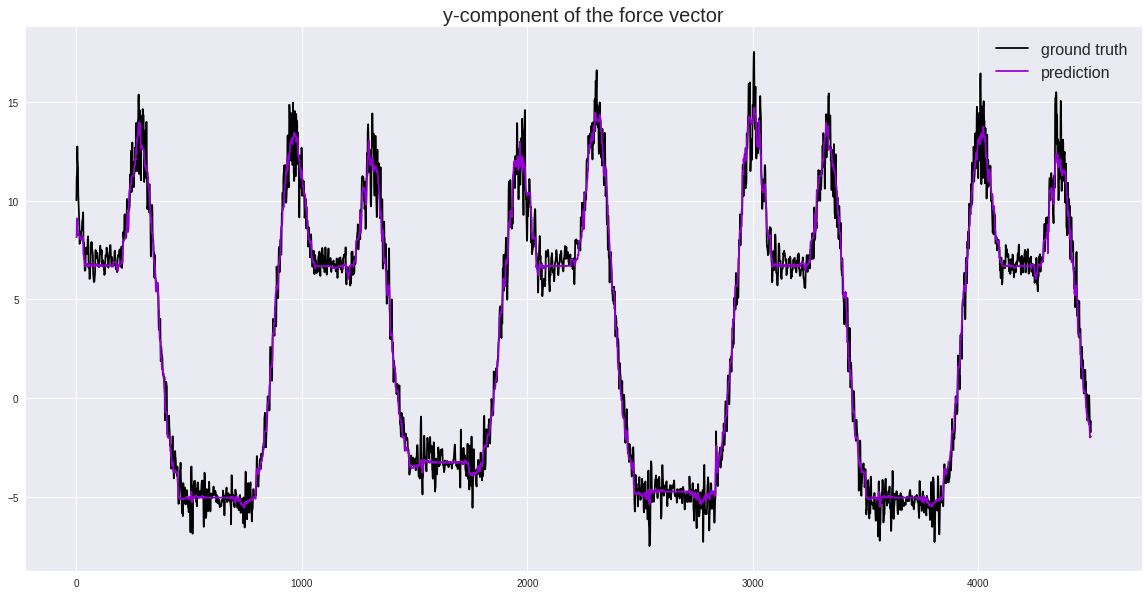

In [28]:
plt.subplots(figsize=(20, 10))

plt.title("y-component of the force vector", size=20)

plt.plot(f_y, label="ground truth", color=col_data)
plt.plot(predictions[:,1], label="prediction",color=col_getml)

plt.legend(loc="upper right", fontsize=16)

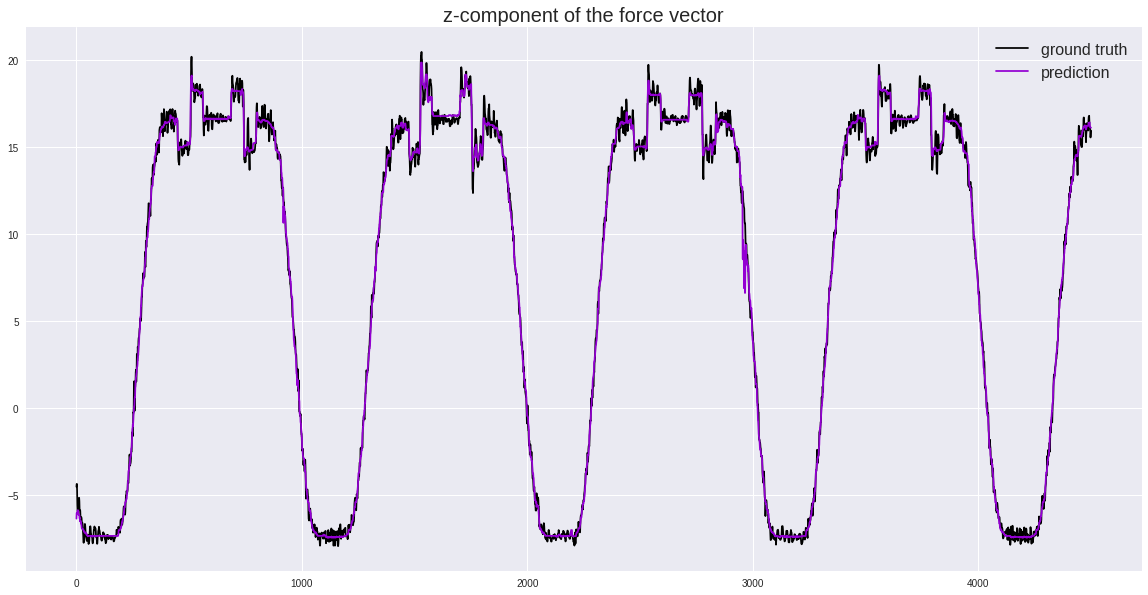

In [29]:
plt.subplots(figsize=(20, 10))

plt.title("z-component of the force vector", size=20)

plt.plot(f_z, label="ground truth", color=col_data)
plt.plot(predictions[:,2], label="prediction",color=col_getml)

plt.legend(loc="upper right", fontsize=16)

As we can see, the predictions are very accurate. This suggests that it is very feasible to predict the force vector based on other sensor data.

## 3. Conclusion


The purpose of this notebook has been to illustrate the problem of the curse of dimensionality when engineering features from datasets with many columns.

The most important thing to remember is that this problem exists regardless of whether you engineer your features manually or using algorithms. Whether you like it or not: If you write your features in the traditional way, your search space grows quadratically with the number of columns.

# Next Steps

This tutorial explained how to overcome the problem of feature explosion with getML's feature learning algorithms Multirel and Relboost. 

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples. 

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.